# Simulación del precio de bitcoin con el método de Monte Carlo

Vamos a lanzarnos a realizar una simulación del precio de bitcoin con el método de Monte Carlo junto con el modelo Black-Scholes-Merton y así calcular las diferentes predicciones del precio desde hace un año hasta hoy.
Es una simulación con cierta maldad, ya que hace un año estábamos cerca del máximo de precio (ATH) y este último año el precio de BTC ha sufrido una de las mayores caídas de su historia, pero es justamente eso lo que queremos ver que porcentaje de los caminos generados por este método se acercan a la realidad actual del precio BTC, en uno de los escenarios más complicados que se pueden dar.
Aclarar, antes que nada, que una simulación de Monte Carlo con la ecuación de Black-Shcoles-Merton no tiene pinta de ser un buen método para predecir el precio de bitcoin a tan largo plazo, ya que el grado de aletoriedad es muy alto de este debido a la variabilidad de la oferta y la demanda, la difícultad de estimar un posible valor fundamental al no haber activos subyacentes y además estar influenciado por los datos macroeconomía que al final interviene como una variable exógena, hacen, en mi opinión, que la evolución del precio sea incalculable a una año vista.

# ¿Qué es el método de Monte Carlo?

Son un conjunto de técnicas que permiten obtener soluciones a problemas matemáticos, físicos, económicos... por medio de pruebas aleatorias repetidas.

Con el método de Monte Carlo se generan posibles escenarios resultantes (simulaciones) a partir de una serie de datos iniciales y una o varias variables aleatorias, las diferentes soluciones resultantes se pueden utilizar para calcular fórmulas, como en el caso del cálculo del número pi, para pronosticar posibles escenarios futuros como en el caso que trataremos aquí al usarlo junto a la ecuación estocástica de Black-Sholes-Merton y para otros muchos usos dentro de la matemática, física, economía...

Se instala el módulo de finanzas para Python de Yahoo.

In [ ]:
 !pip install yfinance > /dev/null

Se importan las bibliotecas que se utilizarán en el estudio.

In [ ]:
import pandas as pd
import numpy as np
import math
from time import time
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

Se descargan los datos del precio de bitcoin de Yahoo finance.

In [ ]:
df = yf.download('BTC-USD', interval = '1d')[['Close']]

[*********************100%***********************]  1 of 1 completed


Esta es la fórmula del modelo económico de Black-Scholes-Merton (1973 stochastic differential equation (SDE) que utilizaremos para generar la simulación.

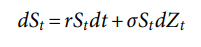

Se utiliza la versión discretizada de Euler de SDE para que sea más fácil convertirla en código Python.

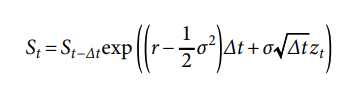

Cálculo de los parámetros necesarios para la ecuación

In [ ]:
# Parameters: sigma, r, S0, dt, I

# Calculation of volatility, in the formula it refers to the intrinsic but we will use the annualized
volatility_days = 30
df['pct_change'] = df['Close'].pct_change()*100
df['stdev'] = df['pct_change'].rolling(volatility_days).std()

# Number of annual daily sessions. In the case of the stock market it is 252 but for bitcon it is 365 because it works every day
df['vol'] = df['stdev']*(365**0.5)
df.dropna(inplace=True)

sigma = df.vol.mean() / 100

# Maturity. Option expiration date. We set it to 1
T = 1

# Calculation of r (riskless short rate)
# The rate of return expected by investors (r) can be estimated from the CAMP model
# r = rf + beta * mrp
# rf: is the risk-free rate -> rf = 0.0020
# mrp: is a market risk premium. -> mrp = 0.0438
r = 0.0020 + 0.94 * 0.0438

# The number of days to simulate
M = 365

# Closing price of bitcoin from which the simulation will start
S0 = df.Close[-M]

# Length of time interval
dt = T / M

# Number of paths to simulate
I = 20000 

print("S0, initial day: \t", S0)
print("r, riskless short rate: ", r)
print("M, number of days: \t", M)
print("I, paths simulating: \t", I)

S0, initial day: 	 56280.42578125
r, riskless short rate:  0.043171999999999995
M, number of days: 	 365
I, paths simulating: 	 20000


In [ ]:
# Simulating I paths with M days (time steps)
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * np.random.standard_normal((M + 1, I)), axis=0))
S[0] = S0

Se muestra la gráfica con 20 simulaciones más la variación del precio real en negro (+).

Text(0, 0.5, 'BTC(USD)')

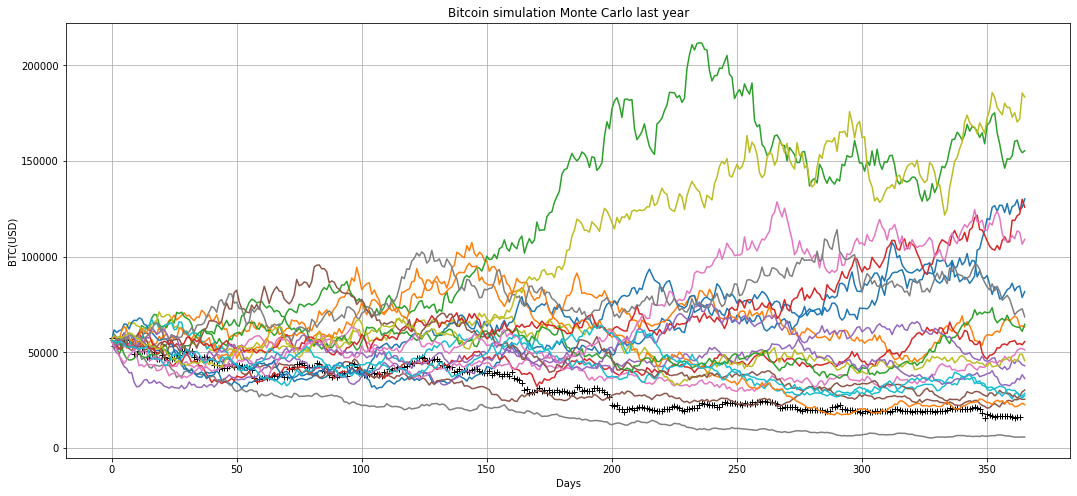

In [ ]:
# Real price ot BTC
real = df[(df.index > df.index[-M])]['Close']

plt.figure(figsize=(18,8))
plt.title('Bitcoin simulation Monte Carlo last year')
plt.plot(real.values, 'k+')
plt.plot(S[:, :20])
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('BTC(USD)')

Gráfico con la distribución de los precios de cierre simulados al final de los 365 días con dos líneas verticales en rojo indicando lo valores por encima y por debajo del 10% y con la línea del precio real en negro.

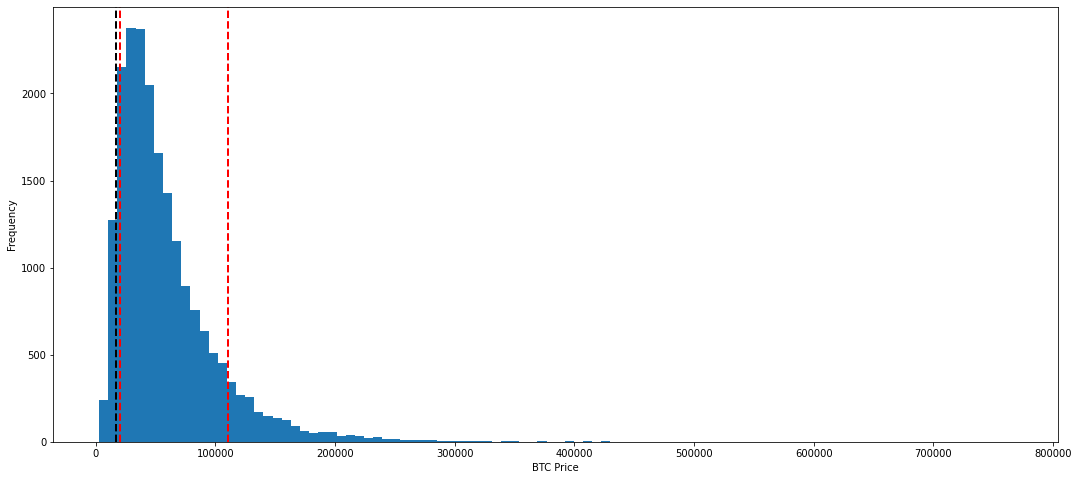

In [ ]:
closing_prices = S[-1]
top_ten = np.percentile(closing_prices, 100-10)

# Pull bottom 10% of possible outcomes
bottom_ten = np.percentile(closing_prices, 10);

plt.figure(figsize=(18,8))
plt.hist(closing_prices, bins=100)
plt.axvline(top_ten,color='r', linestyle='dashed', linewidth=2)
plt.axvline(bottom_ten,color='r', linestyle='dashed', linewidth=2)
plt.axvline(real.values[-1],color='k', linestyle='dashed', linewidth=2)
plt.xlabel('BTC Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Expected BTC price: \t", round(np.mean(closing_prices), 2))
print("Quantile (5%): \t\t", np.percentile(closing_prices, 5))
print("Quantile (95%): \t", np.percentile(closing_prices, 95))

Expected BTC price: 	 58576.6
Quantile (5%): 		 15728.06144884368
Quantile (95%): 	 140307.08467573024


Número de simulaciones que se han generado, de ellas las que tienen un precio inferior al de hoy y el porcentaje que suponen estas con respecto del total.

In [ ]:
df1_T = pd.DataFrame(S[-1:, :I]).T
df1_T.columns = ['btc_price_last_day']
print("Nº simulations: \t\t\t", df1_T.count())
print("Nº simulatios less price today: \t", df1_T[(df1_T['btc_price_last_day'] < df.Close[-1])].count())
print("Average simulatios less price today: \t", df1_T[(df1_T['btc_price_last_day'] < df.Close[-1])].count()*100/df1_T.count())

Nº simulations: 			 btc_price_last_day    20000
dtype: int64
Nº simulatios less price today: 	 btc_price_last_day    1160
dtype: int64
Average simulatios less price today: 	 btc_price_last_day    5.8
dtype: float64


# Conclusiones
Llevamos un año con una de las mayores bajadas de precio de BTC de la historia, se han alidado varios factores, noticas macroeconómicas desfavorables a la economía, la caída de grandes empresas cripto con la pérdida de fondos de sus clientes y además dentro de los periódos cíclicos que se producen cada 4 años en bitcoin debido al halving estamos en la parte que históricamente ha sido bajista.
Como comentábamos al principio la simulación mediante Monte Carlo no nos vale para predecir el precio a un año vista pero si nos vale para saber que de todas los posibles escenarios estamos cerca del 5% peor, lo cual nos indica lo dicho, estamos metidos de lleno en un invierno cripto. 